 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Projet Noté : OPTIMISATION </h2>
<h3> Professeur: Durantin Gautier</h3>
<h4> Étudiants: Bonnet Roman, Pages Hugo </h4>
</div>
    
    

### Objectifs du notebook
    
L’établissement du don du sang se demande quels sont les critères (parmi les 4 proposés) qui 
prédisent le mieux la tendance à donner son sang ou non, afin de mettre en place des règles métier 
pour recontacter certains anciens donneurs. On cherche à éviter d’utiliser des features deux à deux 
redondantes.
    
### Imports
    
Le notebook, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [29]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Visualisation des données
## 1.1 Histogramme
On commence par représenter les données afin de mieux visualiser les differentes catégories. Afin d'observer les données nous affichons 4 histogrammes. 
- Haut gauche : 10 plus gros donneurs par frequences, classé du plus fréquent vers le moins fréquent.  
- Haut droite : 20 donneurs ayant donné le plus récemments , classé du plus récent vers le moins récent.
- Bas gauche  : 10 plus gros donneurs par quantité total de sang donné, classé du plus vers le moins.
- Bas droite  : 20 donneurs ayant donné leur sang pour la première fois depuis le plus longtemps.

remarque : les différentes catégories ayant de valeurs numeriques bien différentes nous utilisons une échelle logarithmique. 

In [30]:
# 1. Chargement et préparation
data = pd.read_csv("transfusion.csv")
data.columns = [c.strip() for c in data.columns] # Nettoyage des noms
data['id Number'] = range(1, len(data) + 1)

# Liste des colonnes numériques pour lesquelles on veut le "Top 10"
name_categories = [
    'Frequency (times)', 
    'Recency (months)', 
    'Monetary (c.c. blood)', 
    'Time (months)'
]



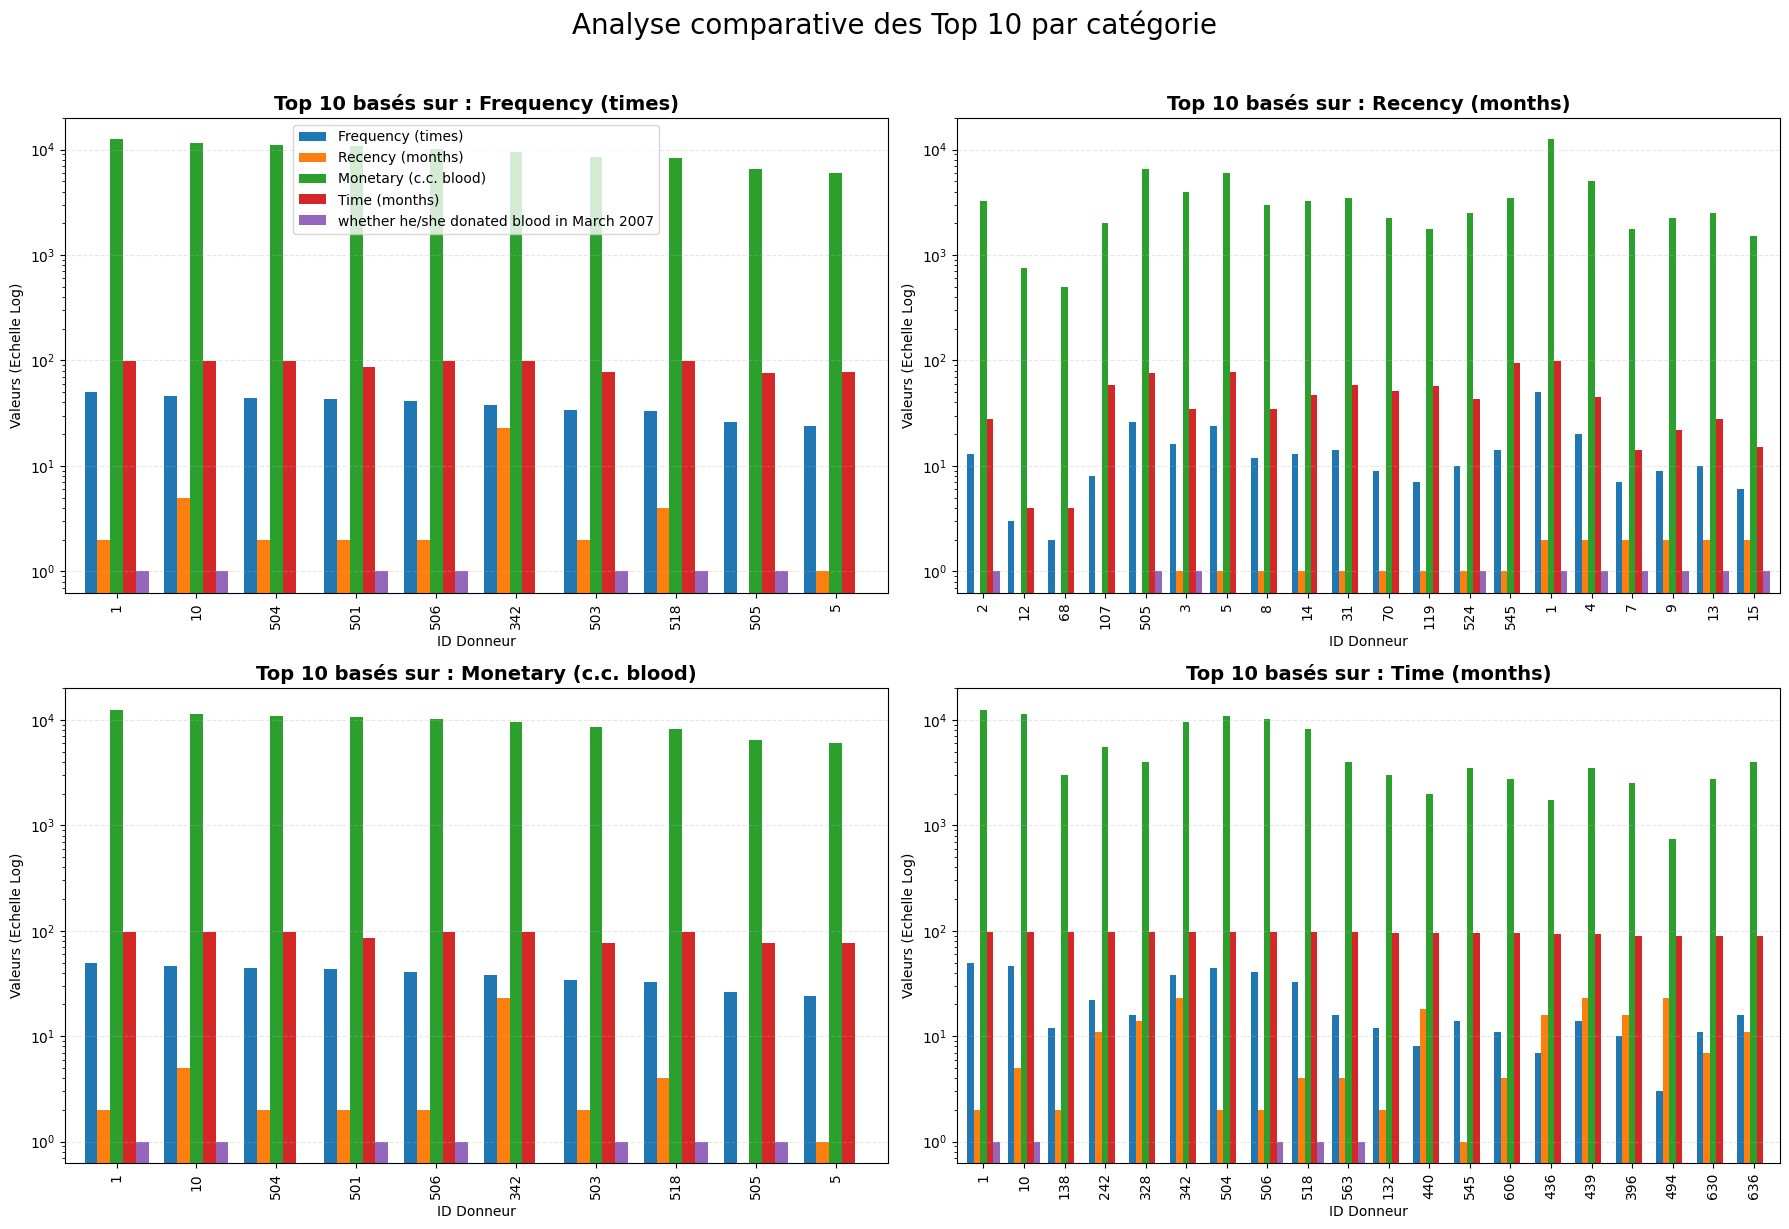

In [31]:



all_cols = name_categories + ['whether he/she donated blood in March 2007']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, cat in enumerate(name_categories):
    if cat == 'Recency (months)':
        # Pour Recency, on prend les 10 plus récents
        top_10 = data.nsmallest(20, cat).sort_values(cat, ascending=True)
    elif cat == 'Time (months)':
        top_10 = data.nlargest(20, cat).sort_values(cat, ascending=False)
    else:
        # Pour Monetary, on prend les 10 plus grands
        top_10 = data.nlargest(10, cat).sort_values(cat, ascending=False)


    plot_data = top_10.set_index('id Number')[all_cols]
    plot_data.plot(kind='bar', ax=axes[i], width=0.8, legend=(i == 0))
    axes[i].set_title(f"Top 10 basés sur : {cat}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs (Echelle Log)")
    axes[i].set_yscale('log') # Echelle log pour comparer Monetary aux autres
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)


plt.suptitle("Analyse comparative des Top 10 par catégorie", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 1.2 Charactéristiques en fonction des donneurs 

In [32]:
Freq=(data['Frequency (times)']/max(data['Frequency (times)'])).to_numpy()
Rec=(data['Recency (months)']/max(data['Recency (months)'])).to_numpy()
Monet=(data['Monetary (c.c. blood)']/max(data['Monetary (c.c. blood)'])).to_numpy()
Time=(data['Time (months)']/max(data['Time (months)'])).to_numpy()

Result=(data['whether he/she donated blood in March 2007']).to_numpy()
All_categories = [Freq, Rec, Monet, Time]

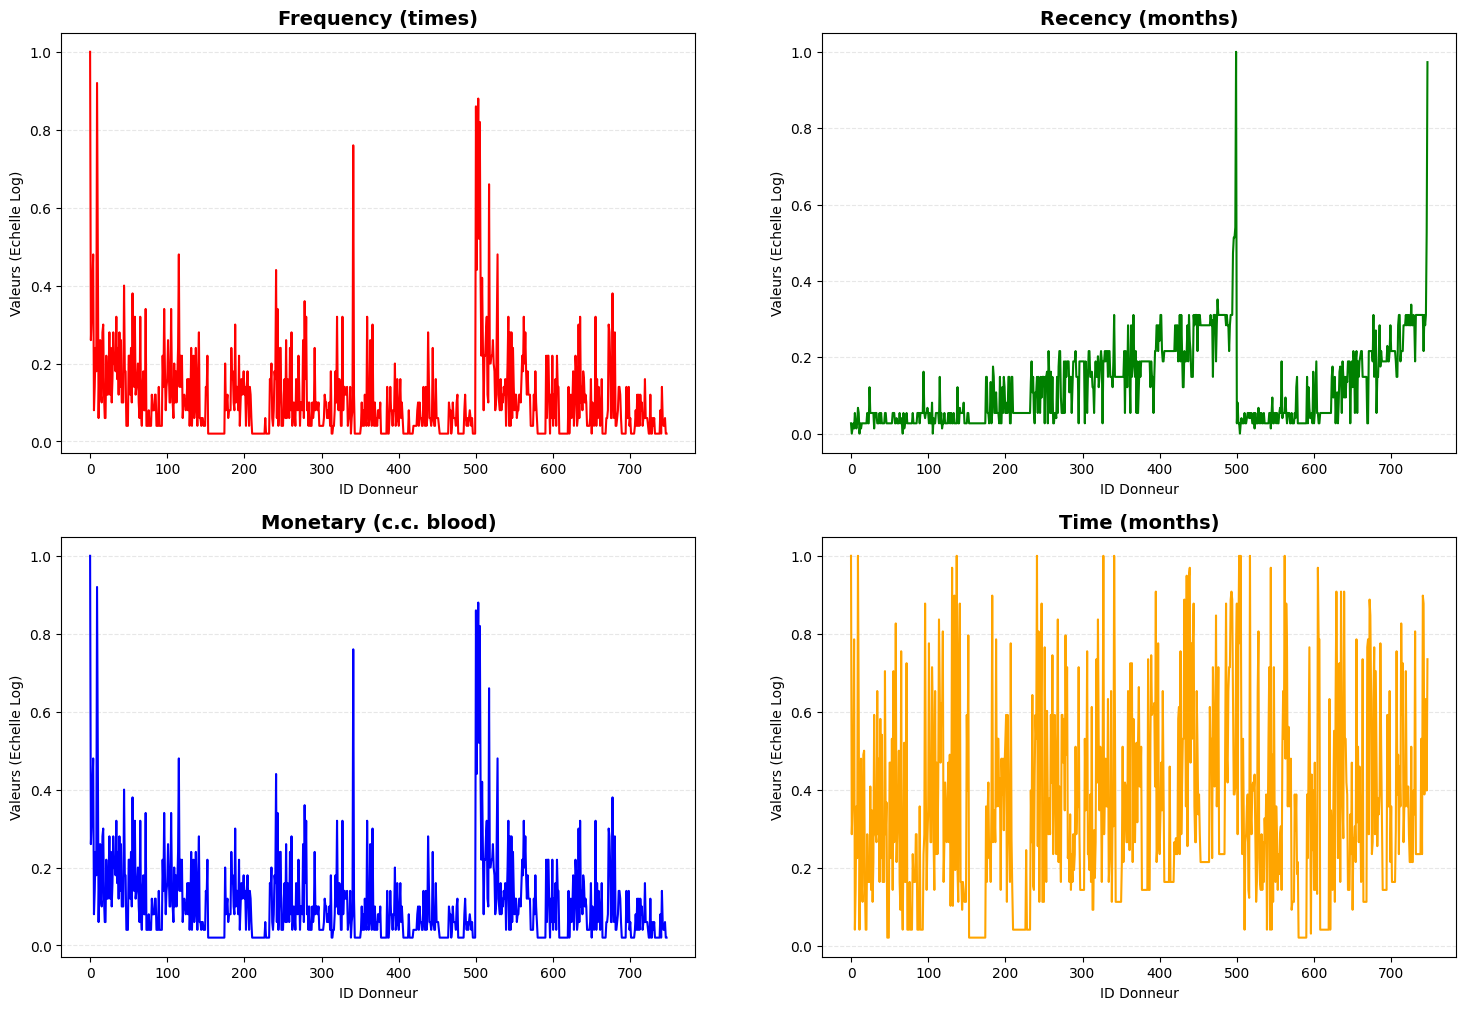

In [33]:
#Chargement de toutes les colonnes


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()
colors=['red', 'green', 'blue', 'orange']
for i, cat in enumerate(All_categories): 
    axes[i].plot(cat, label=name_categories[i], color=colors[i])
    axes[i].set_title(f"{name_categories[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs (Echelle Log)") # Echelle log pour comparer Monetary aux autres
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)



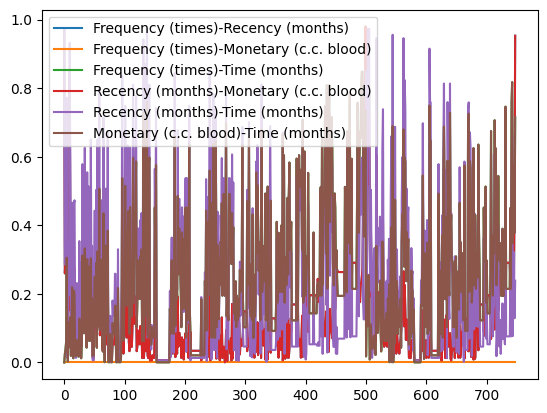

In [34]:

for i in range(len(All_categories)): 
    for j in range(i+1, len(All_categories)): 
        plt.plot(np.abs(All_categories[i]-All_categories[j]), label=f"{name_categories[i]}-{name_categories[j]}")
plt.legend()

# 2. Formulation du problème d'optimisation : 
Notre objectif est de trouver le set de catégories parmis les suivantes: 
-  Frequency : le nombre total de dons effectués par le donneur 
-  Recency : le nombre de mois écoulés depuis le dernier don du sang. 
-  Monetary : le volume total (en centimètres cubes) de sang donné 
-  Time : le nombre de mois écoulés depuis le premier don du sang

qui permets de prevoir si au passage du camion en mars 2007 les donneurs ont donnés oui ou non leurs sang.

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de cout suivante :

$$ C(x) = x^T Q x + c^T x $$

### 2.1. Methodologie


Si on doit choisir parmi $n$ Categories, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant si la catégories est prise en compte ou non. Les $x_i$ valent tous $0$ ou $1$, et représentent si la categorie est choisi ou pas.

Exemple : $X=[1,0,0,1]$ veut dire je prend en compte le frequence de don et le nombre de mois écoulés depuis le premier don du sang  afin de savoir si un donneur va donner ou pas. 

### 2.2. Calcul de la variance

De manière générale, on peut exprimer la variance attendue de la valeur du portefeuille de la manière suivante :

$$ V(x)=\sum_{i=0}^{n-1} Var(i)x_i^2 + \sum_{i \neq j} Covar(i,j)x_ix_j$$

Où $Var(i)$ est la variance de l'action i, et $Covar(i,j)$ est la covariance des actions i et j.

Si on note $\Sigma$ la matrice des variances covariances, de terme $\Sigma_{i,j}=Covar(i,j)$, alors on peut écrire :

$$ V(x) = x^T\Sigma x $$

In [50]:
sigma=np.cov(All_categories)
print(sigma)
mu = np.mean(All_categories, axis=1)  


def get_criterion(x: np.ndarray, sigma: np.ndarray, mu : np.ndarray):
   return -np.dot(x.T, np.dot(sigma, x)) + np.dot(mu, x)


#Exemple 
x1=np.array([0,0,1,0])
x2=np.array([0,1,0,0])

print("critère du portefeuille",x1," :",get_criterion(x1,sigma,mu))
print("critère du portefeuille",x2," :",get_criterion(x2,sigma,mu))

[[ 0.013639   -0.00233477  0.013639    0.01844477]
 [-0.00233477  0.01196776 -0.00233477  0.00437069]
 [ 0.013639   -0.00233477  0.013639    0.01844477]
 [ 0.01844477  0.00437069  0.01844477  0.06187257]]
critère du portefeuille [0 0 1 0]  : 0.09665511457595086
critère du portefeuille [0 1 0 0]  : 0.11650095360014529


In [51]:
import itertools


combinations = list(itertools.product(*[[0,1]]*4))

values = []
for combination in combinations:
  values.append((combination, get_criterion(np.array(combination),sigma,mu)))
  print("Critères choisi :", combination, "Resultat optimisation :", values[-1][1])
best= [comb for comb, val in values if val==min(val for _,val in values)]
print("Meilleurs Critères :", best)



Critères choisi : (0, 0, 0, 0) Resultat optimisation : 0.0
Critères choisi : (0, 0, 0, 1) Resultat optimisation : 0.2879446253246289
Critères choisi : (0, 0, 1, 0) Resultat optimisation : 0.09665511457595086
Critères choisi : (0, 0, 1, 1) Resultat optimisation : 0.3477101969347991
Critères choisi : (0, 1, 0, 0) Resultat optimisation : 0.11650095360014529
Critères choisi : (0, 1, 0, 1) Resultat optimisation : 0.39570420062533174
Critères choisi : (0, 1, 1, 0) Resultat optimisation : 0.2178256101489691
Critères choisi : (0, 1, 1, 1) Resultat optimisation : 0.4601393142083748
Critères choisi : (1, 0, 0, 0) Resultat optimisation : 0.09665511457595086
Critères choisi : (1, 0, 0, 1) Resultat optimisation : 0.3477101969347991
Critères choisi : (1, 0, 1, 0) Resultat optimisation : 0.1660322230096858
Critères choisi : (1, 0, 1, 1) Resultat optimisation : 0.38019776240275327
Critères choisi : (1, 1, 0, 0) Resultat optimisation : 0.2178256101489691
Critères choisi : (1, 1, 0, 1) Resultat optimisa

In [ ]:
#test

def predict(combo): 
    k=0
    for n,val in enumerate(combo): 
        if val == 1 : 
            nouvelle_liste = (All_categories[n] > 0.5).astype(int)
            if k==0:
                res=nouvelle_liste
                k+=1
            else:
                res=np.logical_and(res,nouvelle_liste)
    return res

def compare_predictions(combo):
    preds = predict(combo)
    return (preds == Result).mean() * 100

crit=[(0,0,0,1), (0,0,1,0),(0,1,0,0),(1,0,0,0)]
for c in crit:
    acc=compare_predictions(c)
    print("Critère :",c,"-> Précision sur les positifs :",acc)


Critère : (0, 0, 0, 1) -> Précision sur les positifs : 30.213903743315505
Critère : (0, 0, 1, 0) -> Précision sur les positifs : 65.10695187165776
Critère : (0, 1, 0, 0) -> Précision sur les positifs : 37.032085561497325
Critère : (1, 0, 0, 0) -> Précision sur les positifs : 65.10695187165776
